In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

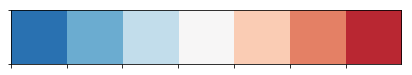

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


In [6]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão  DEZ a MAR
print len(df)
df.head(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
600,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 00:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 01:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 02:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Pré-processamento

<h3>Limpeza dos dados</h3>

In [7]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [8]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [9]:
dfcont = dfcont.apply(pd.to_numeric, errors='coerce')  

In [10]:
dfcont.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3206856 entries, 600 to 9774775
Data columns (total 17 columns):
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: float64(17)
memory usage: 440.4 MB


In [11]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,594823.0,1.244019,3.534589,0.0,0.000,0.200,0.800,100.000
stp,3206856.0,871.062130,259.613938,0.0,909.100,941.700,969.500,1050.000
smax,3206856.0,871.009694,260.134167,0.0,909.300,942.000,969.700,1049.100
smin,3206856.0,870.524392,259.991361,0.0,908.800,941.400,969.200,1048.100
gbrd,1867241.0,1327.603616,1226.852731,0.0,132.523,1030.932,2338.961,9173.064
temp,3206856.0,22.195866,7.324802,-2.8,20.200,23.000,26.300,44.900
tmax,3206841.0,17.297762,5.658299,-10.0,16.600,18.700,20.500,42.000
tmin,3206856.0,22.799069,7.576136,0.0,20.700,23.600,27.200,45.000
dewp,3206840.0,17.823554,5.776646,-10.0,17.200,19.300,21.000,44.800
dmax,3206856.0,21.616621,7.095030,-6.9,19.800,22.500,25.500,45.000


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [15]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
tmax,3206841.0,17.297762,5.658299,-10.0,16.6,18.7,20.5,42.0
tmin,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dewp,3206840.0,17.823554,5.776646,-10.0,17.2,19.3,21.0,44.8
dmax,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206837.0,16.782890,5.583865,-10.0,16.0,18.2,20.0,44.9


<p>A temperatura será inputada pela média</p>

In [16]:
MEAN = ['temp','dewp']

In [17]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())

In [18]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
tmax,3206841.0,17.297762,5.658299,-10.0,16.6,18.7,20.5,42.0
tmin,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dewp,3206856.0,17.823561,5.776632,-10.0,17.2,19.3,21.0,44.8
dmax,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206837.0,16.782890,5.583865,-10.0,16.0,18.2,20.0,44.9


In [19]:
for v in ['tmax','tmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['temp'])
    df[v] = df[v].fillna(value=df['temp'])
for v in ['dmax','dmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['dewp'])
    df[v] = df[v].fillna(value=df['dewp'])
for v in ['hmax','hmin']:
    dfcont[v] = dfcont[v].fillna(value=dfcont['hmdy'])
    df[v] = df[v].fillna(value=df['hmdy'])

In [20]:
dfcont.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,3206856.0,0.230747,1.597225,0.0,0.0,0.0,0.0,100.0
stp,3206856.0,871.062130,259.613938,0.0,909.1,941.7,969.5,1050.0
smax,3206856.0,871.009694,260.134167,0.0,909.3,942.0,969.7,1049.1
smin,3206856.0,870.524392,259.991361,0.0,908.8,941.4,969.2,1048.1
temp,3206856.0,22.195866,7.324802,-2.8,20.2,23.0,26.3,44.9
tmax,3206856.0,17.297780,5.658298,-10.0,16.6,18.7,20.5,42.0
tmin,3206856.0,22.799069,7.576136,0.0,20.7,23.6,27.2,45.0
dewp,3206856.0,17.823561,5.776632,-10.0,17.2,19.3,21.0,44.8
dmax,3206856.0,21.616621,7.095030,-6.9,19.8,22.5,25.5,45.0
dmin,3206856.0,16.782836,5.583923,-10.0,16.0,18.2,20.0,44.9


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t. Vamos primeiramente derivá-las para depois verificar quais quando massivamente as variávies estão zeradas, o que pode indicar que a estação falhou.</p>

<p>Utilizando um exemplo especifico de uma estação, depois verificamos o conjunto maior</p> 

In [21]:
dfm = df

In [22]:
len(dfm)

3206856

In [23]:
dfm.index = pd.to_datetime(dfm.mdct)
dfm.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2007-12-01 00:00:00,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 00:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 01:00:00,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 01:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 02:00:00,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 02:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 03:00:00,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-12-01 03:00:00,2007-12-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
CLEAN = ['wsnm','inme','city','prov','mdct','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.head(5)  

,wsid,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,
2007-12-01 00:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 01:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 02:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 03:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 04:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print ws

[178, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 367, 368, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423]


In [26]:
#dfm = dfm[dfm['wsid'].isin([178, 329])]
#len(dfm)

In [27]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [28]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,3,NON_DER)

In [29]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [30]:
dfr

,wsid,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,...,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3,prcp_1,prcp_2,prcp_3
mdct,,,,,,,,,,,,,,,,,,,,,
2007-12-01 00:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-01 01:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2007-12-01 02:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2007-12-01 03:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 04:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 05:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 06:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 07:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-12-01 08:00:00,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#for w in ws:
#    for col,lag in var:
#        col_name = col + '_'+ lag
#        for i in range(0,int(lag)):
#            idx = dfr.loc[dfr['wsid']==w].index
#            dfr.loc[dfr.loc[idx,col_name].index[int(i)],col_name] = np.nan

In [32]:
dfm = dfr

In [33]:
REMOVE = [u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4', u'prcp_5']
for v in REMOVE:
    dfm = dfm.drop(v,1)

ValueError: labels [u'prcp_4'] not contained in axis

In [34]:
dfm.columns

Index([u'wsid', u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin',
       u'temp', u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax',
       u'hmin', u'wdsp', u'wdct', u'gust', u'wdct_1', u'wdct_2', u'wdct_3',
       u'tmin_1', u'tmin_2', u'tmin_3', u'hmax_1', u'hmax_2', u'hmax_3',
       u'temp_1', u'temp_2', u'temp_3', u'hmin_1', u'hmin_2', u'hmin_3',
       u'gust_1', u'gust_2', u'gust_3', u'tmax_1', u'tmax_2', u'tmax_3',
       u'smax_1', u'smax_2', u'smax_3', u'hmdy_1', u'hmdy_2', u'hmdy_3',
       u'dewp_1', u'dewp_2', u'dewp_3', u'wdsp_1', u'wdsp_2', u'wdsp_3',
       u'stp_1', u'stp_2', u'stp_3', u'smin_1', u'smin_2', u'smin_3',
       u'dmin_1', u'dmin_2', u'dmin_3', u'dmax_1', u'dmax_2', u'dmax_3'],
      dtype='object')

In [35]:
dfm = dfm.reset_index(drop=True)

In [36]:
dfm = dfm.dropna()  

In [37]:
dfm.head(5)

,wsid,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
3,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# como esta rede é especifica para a BH, vamos remover elvt, lat, lon
#REMOVE = ['elvt','lat', 'lon']
#for v in REMOVE:
#    dfm = dfm.drop(v,1)

In [39]:
dfm.head(5)

,wsid,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
3,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,178,237.0,-6.835777,-38.311583,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
CAN_BE_NULL

['wdsp', 'prcp', 'gust']

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [42]:
cols = list(dfm.columns)

COLS_BE_NULL = ['prcp','wdsp','wdsp_1','wdsp_2','wdsp_3','wdsp_4','wdsp_5',\
                'gust','gust_1','gust_2','gust_3','gust_4','gust_5']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)

In [43]:
dfm[cols] = dfm[cols].replace({0.0:np.nan})
dfm.head(5)

,wsid,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
3,178,237.0,-6.835777,-38.311583,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178,237.0,-6.835777,-38.311583,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178,237.0,-6.835777,-38.311583,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178,237.0,-6.835777,-38.311583,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178,237.0,-6.835777,-38.311583,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
dfm = dfm.dropna()

In [45]:
len(dfm)

2797897

In [46]:
dfm.head(5)

,wsid,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
13,178,237.0,-6.835777,-38.311583,0.0,985.3,986.0,985.3,30.1,15.4,...,986.3,986.0,986.2,985.7,15.6,16.8,17.4,26.2,25.1,24.3
14,178,237.0,-6.835777,-38.311583,0.0,984.5,985.3,984.5,31.1,12.8,...,986.3,985.3,986.0,986.2,14.7,15.6,16.8,28.4,26.2,25.1
15,178,237.0,-6.835777,-38.311583,0.0,983.6,984.5,983.6,32.3,12.4,...,986.0,984.5,985.3,986.0,12.6,14.7,15.6,29.9,28.4,26.2
16,178,237.0,-6.835777,-38.311583,0.0,982.6,983.6,982.6,33.2,12.2,...,985.3,983.6,984.5,985.3,12.1,12.6,14.7,31.1,29.9,28.4
17,178,237.0,-6.835777,-38.311583,0.0,981.7,982.6,981.7,34.4,13.2,...,984.5,982.6,983.6,984.5,11.5,12.1,12.6,32.0,31.1,29.9


In [47]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
wsid,2797897.0,357.492991,38.903906,178.000000,327.000000,354.000000,393.000000,423.000000
elvt,2797897.0,594.566203,375.224934,3.000000,288.000000,582.000000,875.000000,1758.000000
lat,2797897.0,-20.270528,2.656046,-24.962819,-22.372832,-20.636526,-18.830354,-6.835777
lon,2797897.0,-44.913626,3.002970,-51.408637,-47.382549,-44.453785,-42.435750,-38.311583
prcp,2797897.0,0.247649,1.652962,0.000000,0.000000,0.000000,0.000000,100.000000
stp,2797897.0,946.454211,40.702848,816.800000,915.400000,946.000000,976.200000,1048.300000
smax,2797897.0,946.720094,40.705375,817.100000,915.700000,946.200000,976.500000,1049.100000
smin,2797897.0,946.190541,40.701275,816.700000,915.200000,945.700000,975.900000,1046.900000
temp,2797897.0,23.887545,4.192058,-2.300000,20.900000,23.400000,26.700000,43.500000
tmax,2797897.0,18.785615,2.564058,-9.800000,17.300000,19.000000,20.600000,37.200000


In [49]:
 dfm = dfm.drop('wsid',1)

<h3>Balanceamento</h3>

<p>Preparação para o balanceamento</p>

In [50]:
#from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [51]:
def f(x):
    if x['prcp'] == 0.0: 
        return 0
    else:        
        return 1    

In [52]:
dfm['type'] = dfm.apply(f,axis=1)

In [53]:
dfm.head(3)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3,type
13,237.0,-6.835777,-38.311583,0.0,985.3,986.0,985.3,30.1,15.4,30.4,...,986.0,986.2,985.7,15.6,16.8,17.4,26.2,25.1,24.3,0
14,237.0,-6.835777,-38.311583,0.0,984.5,985.3,984.5,31.1,12.8,31.8,...,985.3,986.0,986.2,14.7,15.6,16.8,28.4,26.2,25.1,0
15,237.0,-6.835777,-38.311583,0.0,983.6,984.5,983.6,32.3,12.4,32.9,...,984.5,985.3,986.0,12.6,14.7,15.6,29.9,28.4,26.2,0


In [54]:
#Criando bins sem chuva(0mm), com poquisima chuva( até 0.1mm), chuva fraca (> 0.1 até 1.0) \
#e depois agrupando de 5 em 
#bins = np.linspace(dfm.prcp.min(), dfm.prcp.max(), 10)
#bins = [0,0.1,1,5,10,15,20,25,30] 
#types = np.digitize(dfm.prcp, bins)  
#dfm['type'] = types

In [55]:
z = dfm['type'].groupby(dfm['type']).count()
print (z)

type
0    2498467
1     299430
Name: type, dtype: int64


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [56]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [57]:
#dfm = dfm.drop('prcp',1)

In [58]:
target = 'type'

In [59]:
X = dfm[[col for col in dfm.columns if col != target]]

In [60]:
y = dfm[target]

In [61]:
X.head(5)

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
13,237.0,-6.835777,-38.311583,0.0,985.3,986.0,985.3,30.1,15.4,30.4,...,986.3,986.0,986.2,985.7,15.6,16.8,17.4,26.2,25.1,24.3
14,237.0,-6.835777,-38.311583,0.0,984.5,985.3,984.5,31.1,12.8,31.8,...,986.3,985.3,986.0,986.2,14.7,15.6,16.8,28.4,26.2,25.1
15,237.0,-6.835777,-38.311583,0.0,983.6,984.5,983.6,32.3,12.4,32.9,...,986.0,984.5,985.3,986.0,12.6,14.7,15.6,29.9,28.4,26.2
16,237.0,-6.835777,-38.311583,0.0,982.6,983.6,982.6,33.2,12.2,33.7,...,985.3,983.6,984.5,985.3,12.1,12.6,14.7,31.1,29.9,28.4
17,237.0,-6.835777,-38.311583,0.0,981.7,982.6,981.7,34.4,13.2,34.9,...,984.5,982.6,983.6,984.5,11.5,12.1,12.6,32.0,31.1,29.9


<p>Separando o conjunto de treinamento e validação (metade dos 30% separados para validação)</p>

In [62]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=12) 

<p>Executando o balanceamento</p>

In [63]:
from sklearn.decomposition import PCA

In [64]:
pca = PCA(n_components=2)

In [65]:
X_vis = pca.fit_transform(X_train)

In [66]:
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X_train, y_train)
X_res_vis = pca.transform(X_resampled)

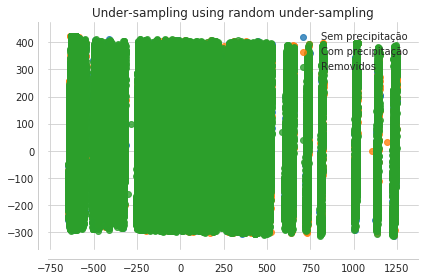

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
plt.scatter(X_res_vis[idx_class_0, 0], X_res_vis[idx_class_0, 1],
            alpha=.8, label=u'Sem precipitação')
plt.scatter(X_res_vis[~idx_class_0, 0], X_res_vis[~idx_class_0, 1],
            alpha=.8, label=u'Com precipitação')
plt.scatter(X_vis[idx_samples_removed, 0], X_vis[idx_samples_removed, 1],
            alpha=.8, label='Removidos')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using random under-sampling')
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
#X_train_over, y_train_over =  SMOTE(random_state=12).fit_sample(X_train, y_train)

In [69]:
len(X_resampled), len(y_resampled)

(418330, 418330)

<p>Reconstruindo o dataframe</p>

In [70]:
#X_train = pd.DataFrame(X_train_over, columns = X_train.columns)
X_train = pd.DataFrame(X_resampled, columns = X_train.columns)

In [71]:
#y_train = pd.DataFrame(y_train_over, columns =['type'])
y_train = pd.DataFrame(y_resampled, columns =['type'])

In [72]:
X_train.head()

,elvt,lat,lon,prcp,stp,smax,smin,temp,tmax,tmin,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
0,525.0,-21.132937,-48.840426,0.0,951.7,951.7,951.5,22.1,20.8,22.6,...,952.9,951.7,952.1,952.9,20.9,21.0,20.9,22.4,23.0,23.5
1,566.0,-22.703132,-47.623317,0.0,947.2,947.4,947.0,21.8,19.8,22.0,...,947.7,947.2,947.6,947.6,19.6,19.3,19.1,21.8,22.2,22.5
2,862.0,-23.228362,-45.417055,0.0,915.9,916.5,915.8,26.2,18.3,26.6,...,917.2,916.5,917.1,917.0,18.5,17.3,17.1,23.0,21.9,20.4
3,734.0,-21.780560,-47.075280,0.0,933.2,933.2,932.5,20.5,19.3,20.6,...,931.1,931.9,931.1,930.9,19.1,19.0,17.5,20.3,20.4,20.2
4,997.0,-17.561349,-47.199251,0.0,904.2,904.2,904.0,20.8,15.6,21.2,...,903.4,903.4,903.3,903.3,15.0,15.6,15.6,20.4,21.7,23.5


In [73]:
#Como o balanceamento SMOTE não serve valores continuos, eu criei classes de chuvas, \
#mas o objetivo ainda persiste em prever o volume de precipitação. Assim vou colocar como alvo a precipitação

<p>Reconstruindo o datafram para alimnar o tensorflow</p>

In [74]:
y_train['prcp'] = X_train['prcp']
y_tmp = X_tmp['prcp']

In [75]:
y_train = y_train.drop('type',1)

In [76]:
X_train = X_train.drop('prcp',1)
X_tmp = X_tmp.drop('prcp',1)

In [77]:
X_tmp.head(3)

,elvt,lat,lon,stp,smax,smin,temp,tmax,tmin,dewp,...,stp_3,smin_1,smin_2,smin_3,dmin_1,dmin_2,dmin_3,dmax_1,dmax_2,dmax_3
704576,283.0,-21.104867,-42.375904,979.6,979.8,979.6,22.0,21.0,22.1,21.3,...,980.4,979.6,980.0,980.4,21.1,21.5,21.5,21.9,22.0,22.1
1403722,641.0,-16.554101,-46.881935,937.9,937.9,937.6,21.9,19.6,21.9,19.7,...,937.3,937.5,937.3,937.2,19.3,19.4,19.3,20.5,20.5,20.5
2140621,367.0,-22.358094,-43.695656,975.7,975.8,975.6,25.7,20.9,26.1,21.5,...,975.1,975.3,975.1,974.7,20.3,20.2,19.8,22.8,20.9,20.4


<p>Separando o conjunto de testes</p>

In [78]:
target = 'prcp'

In [79]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [80]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   418330, Training features   63
Validation instances 419685, Validation features 63
Testing instances    419685, Testing features    63


In [96]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 10000
up = int(len(X_train)/batch_size)

In [97]:
up

41

In [100]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X_train.columns] 

In [101]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units,sd_units],
                                     # activation_fn=activation_fn,
                                      model_dir='/tmp/tf_wx_model-20')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f40502756d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tf_wx_model-20', '_save_summary_steps': 100}


In [102]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [103]:
evaluations = []  
STEPS = 500  
for i in range(1, 100):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 257953500.0, step = 1
INFO:tensorflow:global_step/sec: 1.75273
INFO:tensorflow:loss = 185197.98, step = 101 (57.056 sec)
INFO:tensorflow:global_step/sec: 1.76548
INFO:tensorflow:loss = 334205.12, step = 201 (56.641 sec)
INFO:tensorflow:global_step/sec: 1.74353
INFO:tensorflow:loss = 86480.55, step = 301 (57.355 sec)
INFO:tensorflow:global_step/sec: 1.7469
INFO:tensorflow:loss = 273508.16, step = 401 (57.245 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 281671.34.
INFO:tensorflow:Starting evaluation at 2018-02-19-21:27:31
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-500
INFO:tensorflow:Finished evaluation at 2018-02-19-21:27:52
INFO:tensorflow:Saving dict for global step 500: average_loss = 15.901667, global_step = 500, loss = 158897.4
INFO:t

INFO:tensorflow:Loss for final step: 237638.72.
INFO:tensorflow:Starting evaluation at 2018-02-19-22:03:25
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-4000
INFO:tensorflow:Finished evaluation at 2018-02-19-22:03:46
INFO:tensorflow:Saving dict for global step 4000: average_loss = 9.577404, global_step = 4000, loss = 95702.21
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 159436.56, step = 4001
INFO:tensorflow:global_step/sec: 1.82177
INFO:tensorflow:loss = 17737.664, step = 4101 (54.894 sec)
INFO:tensorflow:global_step/sec: 1.82508
INFO:tensorflow:loss = 219206.1, step = 4201 (54.793 sec)
INFO:tensorflow:global_step/sec: 1.83166
INFO:tensorflow:loss = 17358.992, step = 4301 (54.595 sec)
INFO:tensorflow:global_step/sec: 1.81436
INFO:tensorflow:loss = 211979.84, step = 4401 (55.116 se

INFO:tensorflow:loss = 220660.89, step = 7601 (54.556 sec)
INFO:tensorflow:global_step/sec: 1.84361
INFO:tensorflow:loss = 201207.4, step = 7701 (54.242 sec)
INFO:tensorflow:global_step/sec: 1.83658
INFO:tensorflow:loss = 11712.539, step = 7801 (54.449 sec)
INFO:tensorflow:global_step/sec: 1.81423
INFO:tensorflow:loss = 225377.11, step = 7901 (55.120 sec)
INFO:tensorflow:Saving checkpoints for 8000 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 11701.068.
INFO:tensorflow:Starting evaluation at 2018-02-19-22:43:19
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-8000
INFO:tensorflow:Finished evaluation at 2018-02-19-22:43:41
INFO:tensorflow:Saving dict for global step 8000: average_loss = 4.0182004, global_step = 8000, loss = 40151.867
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-8000
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/tf_wx_model-20/model.ckpt.
I

INFO:tensorflow:Finished evaluation at 2018-02-19-23:18:30
INFO:tensorflow:Saving dict for global step 11500: average_loss = 3.7260513, global_step = 11500, loss = 37232.57
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-11500
INFO:tensorflow:Saving checkpoints for 11501 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 9991.637, step = 11501
INFO:tensorflow:global_step/sec: 1.83494
INFO:tensorflow:loss = 223269.38, step = 11601 (54.499 sec)
INFO:tensorflow:global_step/sec: 1.83389
INFO:tensorflow:loss = 9782.205, step = 11701 (54.530 sec)
INFO:tensorflow:global_step/sec: 1.84381
INFO:tensorflow:loss = 219692.94, step = 11801 (54.234 sec)
INFO:tensorflow:global_step/sec: 1.8446
INFO:tensorflow:loss = 145165.55, step = 11901 (54.213 sec)
INFO:tensorflow:Saving checkpoints for 12000 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 9468.359.
INFO:tensorflow:Starting evaluation at 2018-0

INFO:tensorflow:loss = 179891.02, step = 15201 (55.200 sec)
INFO:tensorflow:global_step/sec: 1.83972
INFO:tensorflow:loss = 8843.592, step = 15301 (54.356 sec)
INFO:tensorflow:global_step/sec: 1.83993
INFO:tensorflow:loss = 8587.682, step = 15401 (54.350 sec)
INFO:tensorflow:Saving checkpoints for 15500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 183846.94.
INFO:tensorflow:Starting evaluation at 2018-02-19-23:57:50
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-15500
INFO:tensorflow:Finished evaluation at 2018-02-19-23:58:11
INFO:tensorflow:Saving dict for global step 15500: average_loss = 6.9731035, global_step = 15500, loss = 69678.734
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-15500
INFO:tensorflow:Saving checkpoints for 15501 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 207380.48, step = 15501
INFO:tensorflow:global_step/sec: 1.83969
INFO:

INFO:tensorflow:Saving dict for global step 19000: average_loss = 6.776653, global_step = 19000, loss = 67715.7
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-19000
INFO:tensorflow:Saving checkpoints for 19001 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 199437.66, step = 19001
INFO:tensorflow:global_step/sec: 1.80558
INFO:tensorflow:loss = 7821.4863, step = 19101 (55.386 sec)
INFO:tensorflow:global_step/sec: 1.80895
INFO:tensorflow:loss = 211439.53, step = 19201 (55.281 sec)
INFO:tensorflow:global_step/sec: 1.80565
INFO:tensorflow:loss = 7842.753, step = 19301 (55.381 sec)
INFO:tensorflow:global_step/sec: 1.79943
INFO:tensorflow:loss = 200674.08, step = 19401 (55.573 sec)
INFO:tensorflow:Saving checkpoints for 19500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 208444.58.
INFO:tensorflow:Starting evaluation at 2018-02-20-00:37:52
INFO:tensorflow:Restoring parameters from /t

INFO:tensorflow:global_step/sec: 1.82353
INFO:tensorflow:loss = 7403.695, step = 22801 (54.839 sec)
INFO:tensorflow:global_step/sec: 1.81269
INFO:tensorflow:loss = 193537.19, step = 22901 (55.167 sec)
INFO:tensorflow:Saving checkpoints for 23000 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 7437.025.
INFO:tensorflow:Starting evaluation at 2018-02-20-01:13:00
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-23000
INFO:tensorflow:Finished evaluation at 2018-02-20-01:13:20
INFO:tensorflow:Saving dict for global step 23000: average_loss = 3.3217878, global_step = 23000, loss = 33192.965
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-23000
INFO:tensorflow:Saving checkpoints for 23001 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 214887.34, step = 23001
INFO:tensorflow:global_step/sec: 1.82744
INFO:tensorflow:loss = 214093.53, step = 23101 (54.723 sec)
INFO:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-26500
INFO:tensorflow:Saving checkpoints for 26501 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 203325.22, step = 26501
INFO:tensorflow:global_step/sec: 1.79215
INFO:tensorflow:loss = 7112.6064, step = 26601 (55.801 sec)
INFO:tensorflow:global_step/sec: 1.79219
INFO:tensorflow:loss = 7136.355, step = 26701 (55.798 sec)
INFO:tensorflow:global_step/sec: 1.8002
INFO:tensorflow:loss = 207677.66, step = 26801 (55.549 sec)
INFO:tensorflow:global_step/sec: 1.80283
INFO:tensorflow:loss = 7194.5547, step = 26901 (55.468 sec)
INFO:tensorflow:Saving checkpoints for 27000 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 201234.1.
INFO:tensorflow:Starting evaluation at 2018-02-20-01:53:11
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-27000
INFO:tensorflow:Finished evaluation at 2018-02-20-01:53:31
INFO:tensorflow:Savi

INFO:tensorflow:global_step/sec: 1.8284
INFO:tensorflow:loss = 210187.61, step = 30401 (54.693 sec)
INFO:tensorflow:Saving checkpoints for 30500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 6807.593.
INFO:tensorflow:Starting evaluation at 2018-02-20-02:28:04
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-30500
INFO:tensorflow:Finished evaluation at 2018-02-20-02:28:24
INFO:tensorflow:Saving dict for global step 30500: average_loss = 3.2062075, global_step = 30500, loss = 32038.03
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-30500
INFO:tensorflow:Saving checkpoints for 30501 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 6704.102, step = 30501
INFO:tensorflow:global_step/sec: 1.79933
INFO:tensorflow:loss = 175757.6, step = 30601 (55.578 sec)
INFO:tensorflow:global_step/sec: 1.80742
INFO:tensorflow:loss = 6771.338, step = 30701 (55.327 sec)
INFO:tens

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-34000
INFO:tensorflow:Saving checkpoints for 34001 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 172906.84, step = 34001
INFO:tensorflow:global_step/sec: 1.78518
INFO:tensorflow:loss = 6586.797, step = 34101 (56.019 sec)
INFO:tensorflow:global_step/sec: 1.79563
INFO:tensorflow:loss = 6805.3555, step = 34201 (55.690 sec)
INFO:tensorflow:global_step/sec: 1.77933
INFO:tensorflow:loss = 174909.66, step = 34301 (56.201 sec)
INFO:tensorflow:global_step/sec: 1.79319
INFO:tensorflow:loss = 6672.294, step = 34401 (55.767 sec)
INFO:tensorflow:Saving checkpoints for 34500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 213489.06.
INFO:tensorflow:Starting evaluation at 2018-02-20-03:08:12
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-34500
INFO:tensorflow:Finished evaluation at 2018-02-20-03:08:33
INFO:tensorflow:Sav

INFO:tensorflow:global_step/sec: 1.7926
INFO:tensorflow:loss = 6398.5083, step = 37901 (55.785 sec)
INFO:tensorflow:Saving checkpoints for 38000 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 203975.97.
INFO:tensorflow:Starting evaluation at 2018-02-20-03:43:30
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-38000
INFO:tensorflow:Finished evaluation at 2018-02-20-03:43:51
INFO:tensorflow:Saving dict for global step 38000: average_loss = 5.834864, global_step = 38000, loss = 58304.883
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-38000
INFO:tensorflow:Saving checkpoints for 38001 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 41225.926, step = 38001
INFO:tensorflow:global_step/sec: 1.79816
INFO:tensorflow:loss = 208832.38, step = 38101 (55.615 sec)
INFO:tensorflow:global_step/sec: 1.8011
INFO:tensorflow:loss = 149715.73, step = 38201 (55.522 sec)
INFO:t

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-41500
INFO:tensorflow:Saving checkpoints for 41501 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 220891.78, step = 41501
INFO:tensorflow:global_step/sec: 1.81621
INFO:tensorflow:loss = 43558.523, step = 41601 (55.061 sec)
INFO:tensorflow:global_step/sec: 1.78854
INFO:tensorflow:loss = 6293.789, step = 41701 (55.912 sec)
INFO:tensorflow:global_step/sec: 1.81719
INFO:tensorflow:loss = 201916.34, step = 41801 (55.030 sec)
INFO:tensorflow:global_step/sec: 1.79998
INFO:tensorflow:loss = 6173.673, step = 41901 (55.557 sec)
INFO:tensorflow:Saving checkpoints for 42000 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 183451.38.
INFO:tensorflow:Starting evaluation at 2018-02-20-04:23:36
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-42000
INFO:tensorflow:Finished evaluation at 2018-02-20-04:23:57
INFO:tensorflow:Sav

INFO:tensorflow:global_step/sec: 1.80916
INFO:tensorflow:loss = 208755.94, step = 45401 (55.274 sec)
INFO:tensorflow:Saving checkpoints for 45500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 6196.798.
INFO:tensorflow:Starting evaluation at 2018-02-20-04:58:37
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-45500
INFO:tensorflow:Finished evaluation at 2018-02-20-04:58:57
INFO:tensorflow:Saving dict for global step 45500: average_loss = 3.0491266, global_step = 45500, loss = 30468.398
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-45500
INFO:tensorflow:Saving checkpoints for 45501 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 219338.72, step = 45501
INFO:tensorflow:global_step/sec: 1.78554
INFO:tensorflow:loss = 194863.97, step = 45601 (56.007 sec)
INFO:tensorflow:global_step/sec: 1.80341
INFO:tensorflow:loss = 6376.908, step = 45701 (55.451 sec)
INFO:

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-49000
INFO:tensorflow:Saving checkpoints for 49001 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:loss = 180022.05, step = 49001
INFO:tensorflow:global_step/sec: 1.81893
INFO:tensorflow:loss = 6190.7974, step = 49101 (54.979 sec)
INFO:tensorflow:global_step/sec: 1.81329
INFO:tensorflow:loss = 6058.918, step = 49201 (55.148 sec)
INFO:tensorflow:global_step/sec: 1.7971
INFO:tensorflow:loss = 184009.75, step = 49301 (55.646 sec)
INFO:tensorflow:global_step/sec: 1.80761
INFO:tensorflow:loss = 6170.292, step = 49401 (55.321 sec)
INFO:tensorflow:Saving checkpoints for 49500 into /tmp/tf_wx_model-20/model.ckpt.
INFO:tensorflow:Loss for final step: 188999.56.
INFO:tensorflow:Starting evaluation at 2018-02-20-05:38:35
INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-20/model.ckpt-49500
INFO:tensorflow:Finished evaluation at 2018-02-20-05:38:55
INFO:tensorflow:Savi

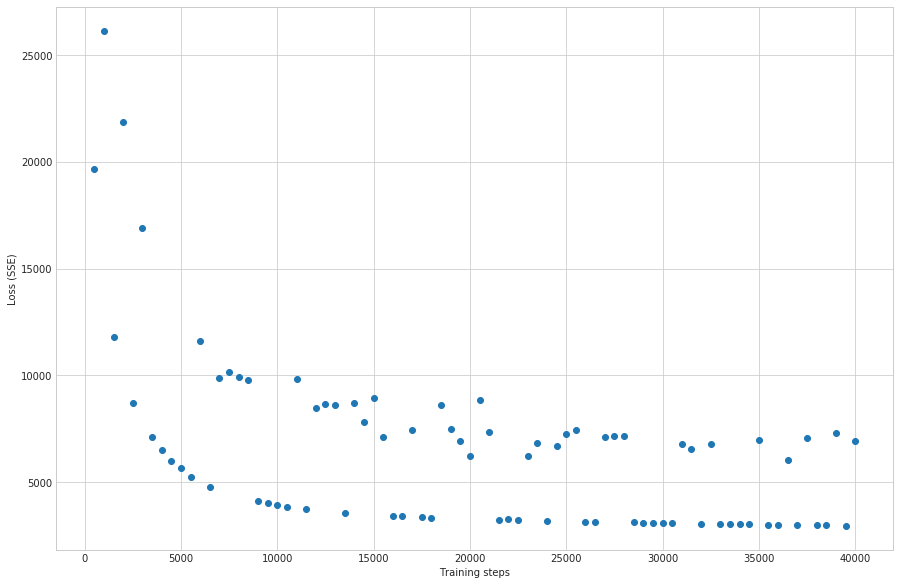

In [90]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [91]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Restoring parameters from /tmp/tf_wx_model-18/model.ckpt-40500


In [92]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f mm " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f mm" % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: -0.03
The Mean Absolute Error: 0.62 mm 
The Median Absolute Error: 0.35 mm


In [93]:
predictions

array([ 0.66619366,  0.19342299,  0.6047084 , ...,  0.552241  ,
        0.39023083, -0.64644367], dtype=float32)

In [94]:
predictions.size

419685

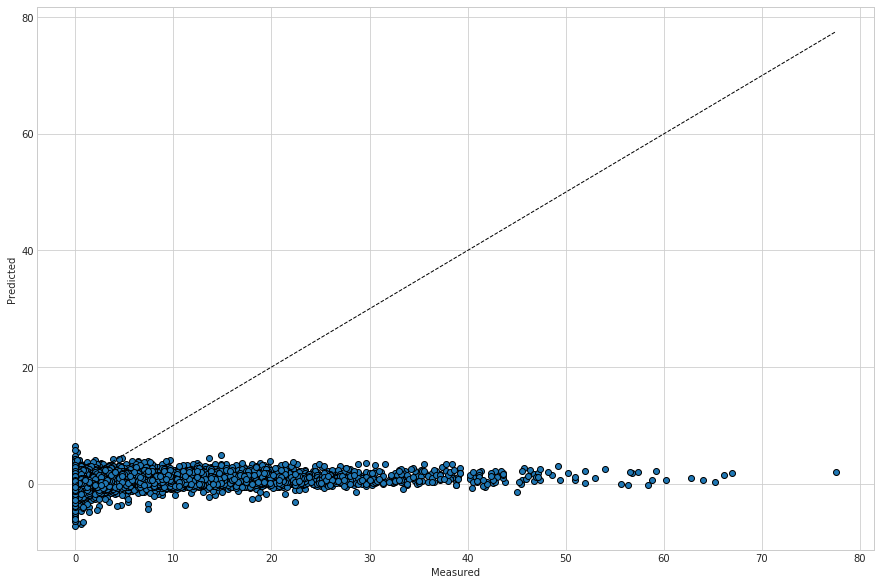

In [104]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()